# Feature-based Augmented Reality App

By Fabiano Junior Maia Manschein (235321) - IMLEX

A feature-based augmented reality app made with Python and OpenCV. Uses feature matching to calculate camera pose, homography, and render the 3D object.

# Imports and setup

In [1]:
import cv2
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
from ar_app.objloader_simple import *

# Load Marker and Source images

I'll test 2 different markers: HIRO and my own custom marker (a drawing of me):

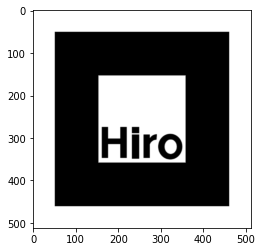

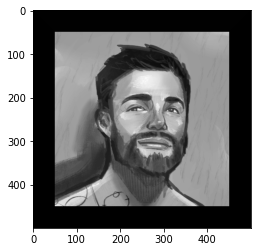

In [2]:
ref_image = cv2.imread('./img/hiro.png', 0)
ref_image2 = cv2.imread('./img/me-marker.png', 0)

plt.imshow(ref_image, cmap='gray')
plt.show()
plt.imshow(ref_image2, cmap='gray')
plt.show()

I'll also test different variants of source images: 3 for HIRO, 2 for me.

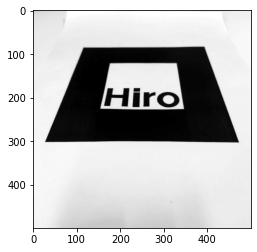

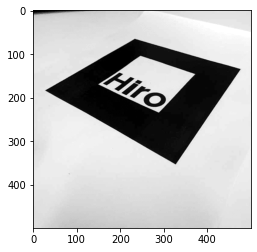

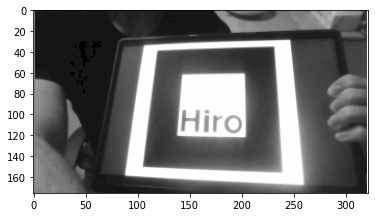

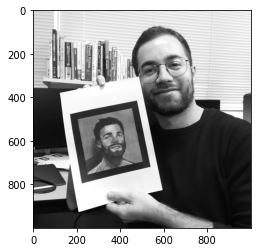

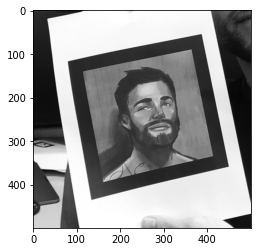

In [3]:
src_image = cv2.imread('./img/src_hiro-front.png', 0)
src_image2 = cv2.imread('./img/src_hiro-diagonal.png', 0)
src_image3 = cv2.imread('./img/src_hiro-webcam.png', 0)
src_image4 = cv2.imread('./img/src_me.png', 0)
src_image5 = cv2.imread('./img/src_me-crop.png', 0)

plt.imshow(src_image, cmap='gray')
plt.show()
plt.imshow(src_image2, cmap='gray')
plt.show()
plt.imshow(src_image3, cmap='gray')
plt.show()
plt.imshow(src_image4, cmap='gray')
plt.show()
plt.imshow(src_image5, cmap='gray')
plt.show()

Images are converted to gray scale for better processing.

# Feature detection

We'll use features and their description to identify markers. As such, we have to extract them from both the reference and the source image.

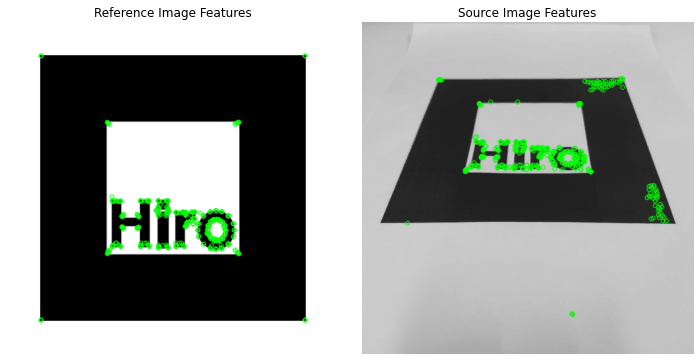

In [4]:
# Initiate ORB detector
orb = cv2.ORB_create()

def feature_detection(ref_image, src_image, orb):
    # find the keypoints with ORB
    ref_image_pts = orb.detect(ref_image, None)
    src_image_pts = orb.detect(src_image, None)

    # compute the descriptors with ORB
    ref_image_pts, ref_image_dsc = orb.compute(ref_image, ref_image_pts)
    src_image_pts, src_image_dsc = orb.compute(src_image, src_image_pts)

    ref_image_features = cv2.drawKeypoints(
        ref_image, ref_image_pts, ref_image, color=(0, 255, 0), flags=0
    )
    src_image_features = cv2.drawKeypoints(
        src_image, src_image_pts, src_image, color=(0, 255, 0), flags=0
    )

    return ref_image_features, src_image_features

ref_image_features, src_image_features = feature_detection(ref_image, src_image, orb)

def draw_features(ref_image_features, src_image_features):
    # Show image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(ref_image_features, cmap='gray')
    plt.title('Reference Image Features')
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.imshow(src_image_features, cmap='gray')
    plt.title('Source Image Features')
    plt.tight_layout()
    plt.show()

draw_features(ref_image_features, src_image_features)

# Feature matching

Match detected features using the Brute-Force Matcher from OpenCV.

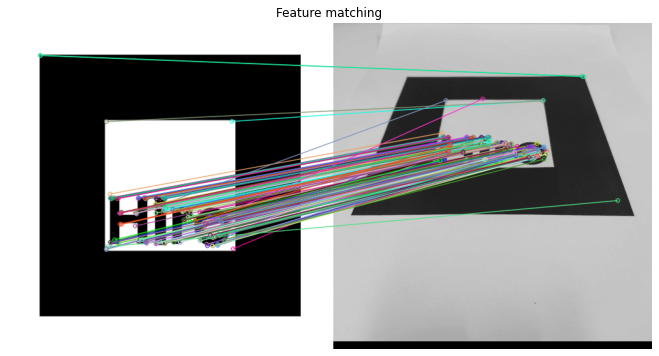

In [5]:
MIN_MATCHES = 30
            
# create brute force  matcher object
bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

def feature_matching(ref_image, src_image, orb, bf_matcher):
    # Compute model keypoints and its descriptors
    ref_image_pts, ref_image_dsc = orb.detectAndCompute(ref_image, None)

    # Compute scene keypoints and its descriptors
    src_image_pts, src_image_dsc = orb.detectAndCompute(src_image, None)

    # Match frame descriptors with model descriptors
    matches = bf_matcher.match(ref_image_dsc, src_image_dsc)

    # Sort them in the order of their distance
    matches = sorted(matches, key=lambda x: x.distance)

    return ref_image_pts, src_image_pts, matches

ref_image_pts, src_image_pts, matches = feature_matching(ref_image, src_image, orb, bf_matcher)

def draw_matches(ref_image, src_image, ref_image_pts, src_image_pts, matches, min_matches=MIN_MATCHES):
    if len(matches) > min_matches:
        # Draw matches
        matches_img = cv2.drawMatches(ref_image, ref_image_pts, src_image, src_image_pts, matches, 0, flags=2)
        # show result
        plt.figure(figsize=(12, 6))
        plt.axis('off')
        plt.imshow(matches_img, cmap='gray')
        plt.title('Feature matching')
        plt.show()
        return 1
        
    else:
        print("Not enough matches have been found - %d/%d" % (len(matches), MIN_MATCHES))
        matchesMask = None
        return matchesMask

matches_mask = draw_matches(ref_image, src_image, ref_image_pts, src_image_pts, matches)

# Homography

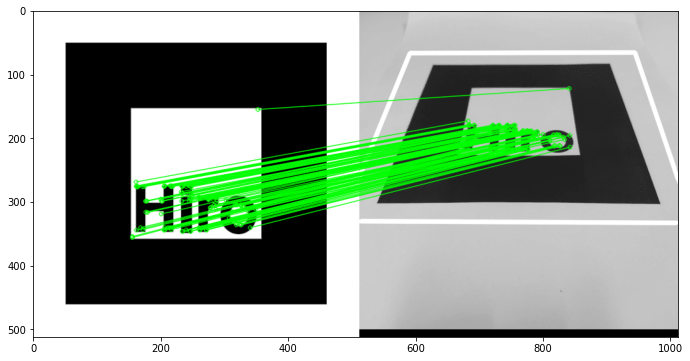

In [6]:
def find_homography(ref_image, src_image, ref_image_pts, src_image_pts, matches, min_matches=MIN_MATCHES):
    # Apply the homography transformation if we have enough good matches
    if len(matches) > min_matches:
        # Get the good key points positions
        homography_src_pts = np.float32([ref_image_pts[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        homography_dst_pts = np.float32([src_image_pts[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

        # Obtain the homography matrix
        homography, mask = cv2.findHomography(homography_src_pts, homography_dst_pts, cv2.RANSAC, 5.0)
        matches_mask = mask.ravel().tolist()

        # Apply the perspective transformation to the source image corners
        h, w = ref_image.shape
        corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
        transformedCorners = cv2.perspectiveTransform(corners, homography)

        # Draw a polygon on the second image joining the transformed corners
        src_image_marker = cv2.polylines(src_image, [np.int32(transformedCorners)], True,
                                        255, 5, cv2.LINE_AA)
        
        return homography, matches_mask, src_image_marker, transformedCorners

    else:
        print("Not enough matches are found - %d/%d" % (len(matches), MIN_MATCHES))
        matches_mask = None
        return None, matches_mask, None, None

homography, matches_mask, src_image_marker, transformedCorners = find_homography(ref_image, src_image, ref_image_pts, src_image_pts, matches, min_matches=MIN_MATCHES)

def draw_masked_matches(ref_image, ref_image_pts, src_image_marker, src_image_pts, matches, matches_mask):
    # Draw the matches
    drawParameters = dict(matchColor=(0, 255, 0), singlePointColor=None,
                        matchesMask=matches_mask, flags=2)
    result = cv2.drawMatches(ref_image, ref_image_pts, src_image_marker,
                            src_image_pts, matches, None, **drawParameters)

    # Show image
    plt.figure(figsize=(12, 6))
    plt.imshow(result, cmap='gray')
    plt.show()

draw_masked_matches(ref_image, ref_image_pts, src_image_marker, src_image_pts, matches, matches_mask)

## Rendering the 3D model

Load the model

In [7]:
from ar_app.objloader_simple import OBJ

# Camera parameters
camera_parameters = np.array([[500, 0, 240], [0, 500, 300], [0, 0, 1]])

# Load 3D model from OBJ file
obj = OBJ('./models/fox/fox.obj', swapyz=True)

Calculate the projection matrix

In [8]:
def projection_matrix(camera_parameters, homography):
    
    homography = homography * (-1)
    rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
    col_1 = rot_and_transl[:, 0]
    col_2 = rot_and_transl[:, 1]
    col_3 = rot_and_transl[:, 2]
    
    # normalise vectors
    l = math.sqrt(np.linalg.norm(col_1, 2) * np.linalg.norm(col_2, 2))
    rot_1 = col_1 / l
    rot_2 = col_2 / l
    translation = col_3 / l
    
    # compute the orthonormal basis
    c = rot_1 + rot_2
    p = np.cross(rot_1, rot_2)
    d = np.cross(c, p)
    rot_1 = np.dot(c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_2 = np.dot(c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_3 = np.cross(rot_1, rot_2)
    
    # finally, compute the 3D projection matrix from the model to the current frame
    projection = np.stack((rot_1, rot_2, rot_3, translation)).T
    
    return np.dot(camera_parameters, projection)

Render the model

In [9]:
# project cube or model
SCALE = 2  # Default 6
def render(img, obj, projection, model, color=False):

    vertices = obj.vertices
    scale_matrix = np.eye(3) * SCALE
    h, w = model.shape

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        points = np.dot(points, scale_matrix)
        # render model in the middle of the reference surface. To do so,
        # model points must be displaced
        points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
        dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
        imgpts = np.int32(dst)

        cv2.fillConvexPoly(img, imgpts, (80, 27, 211))
    return img

Apply everything to render the model with applied homography

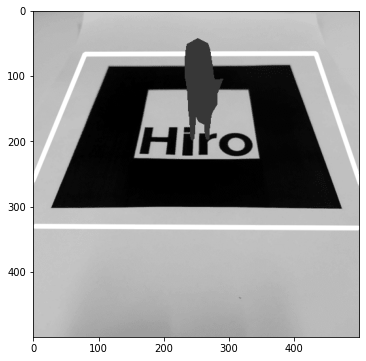

In [10]:
def draw_result(src_image, transformedCorners, homography):
    # Draw a polygon on the second image joining the transformed corners
    render_image = np.copy(src_image)
    frame = cv2.polylines(render_image, [np.int32(transformedCorners)], True, 255, 3, cv2.LINE_AA)

    # obtain 3D projection matrix from homography matrix and camera parameters
    projection = projection_matrix(camera_parameters, homography)  

    # project cube or model
    frame = render(frame, obj, projection, ref_image, False)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.imshow(frame, cmap="gray")
    plt.show()

draw_result(src_image, transformedCorners, homography)

# Results from other markers and images

First we setup the pipeline:

In [11]:
def pipeline(ref_image, src_image, orb, bf_matcher):
    # Features
    ref_image_features, src_image_features = feature_detection(ref_image, src_image, orb)
    draw_features(ref_image_features, src_image_features)

    # Matching
    ref_image_pts, src_image_pts, matches = feature_matching(ref_image, src_image, orb, bf_matcher)
    matches_mask = draw_matches(ref_image, src_image, ref_image_pts, src_image_pts, matches)
    
    # Homography
    homography, matches_mask, src_image_marker, transformedCorners = find_homography(ref_image, src_image, ref_image_pts, src_image_pts, matches, min_matches=MIN_MATCHES)
    draw_masked_matches(ref_image, ref_image_pts, src_image_marker, src_image_pts, matches, matches_mask)

    # Rendering
    draw_result(src_image, transformedCorners, homography)


And then we apply it to each of our inputs:
- `ref_image` has 3 source images: `src_image`, `src_image2`, `src_imagr3`
- `ref_image2` has 2 source images: `src_image4`, `src_image5`

Since we already tested `src_image`, we'll proceed with the other 2 for `ref_image`.

In [12]:
pipeline(ref_image, src_image2, orb, bf_matcher)

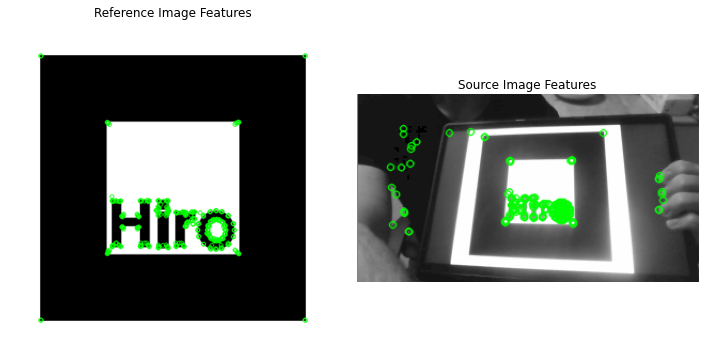

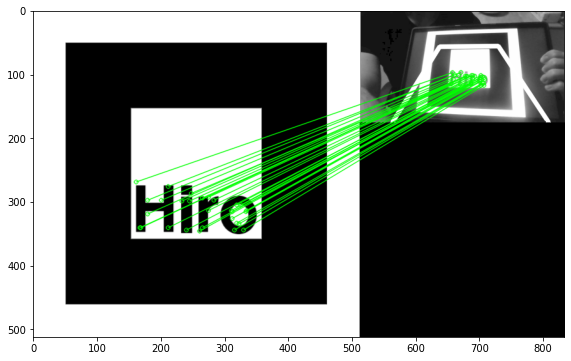

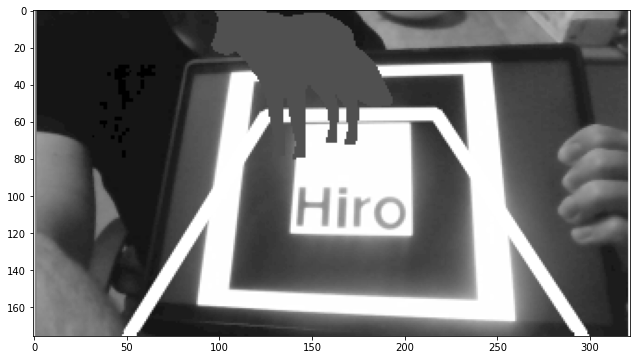

In [13]:
pipeline(ref_image, src_image3, orb, bf_matcher)

We can clearly see that the webcam source image performed the worst, despite the features correctly matching to the hiro marker. This is likely due to bad calibration of camera parameters.

Next, we experiment with my own marker.

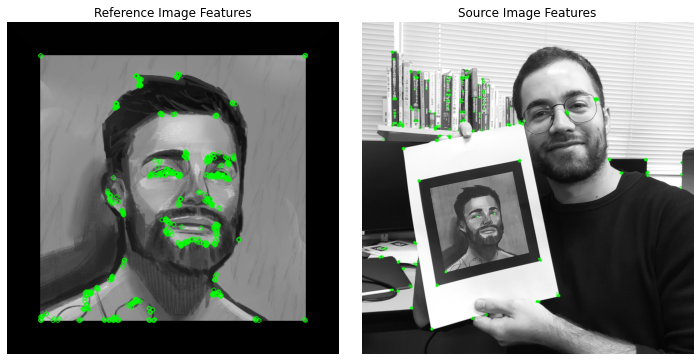

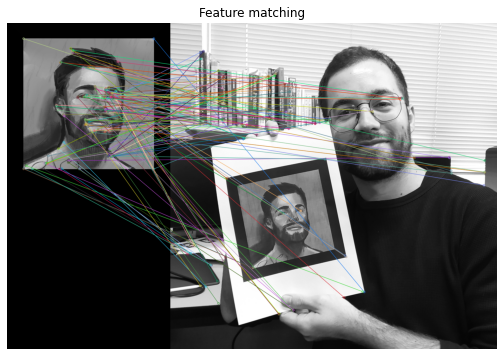

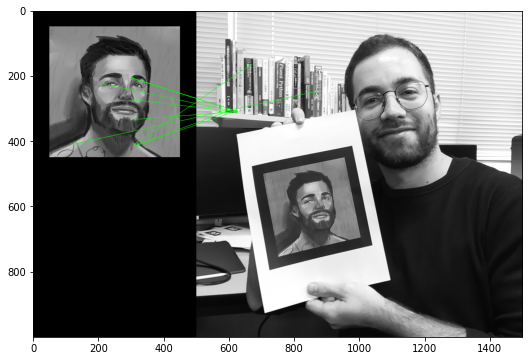

In [14]:
pipeline(ref_image2, src_image4, orb, bf_matcher)

This image failed to get the correct features. It seems the background caused a lot of noise in the feature detection. `src_image5` addresses this issue by cropping everything except the marker.

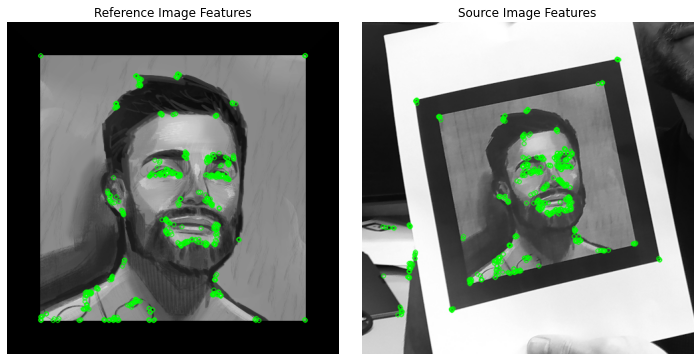

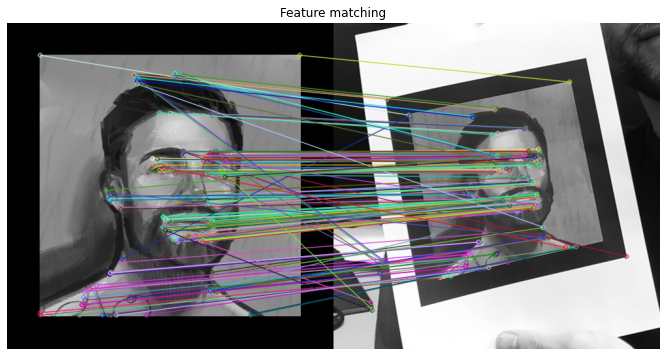

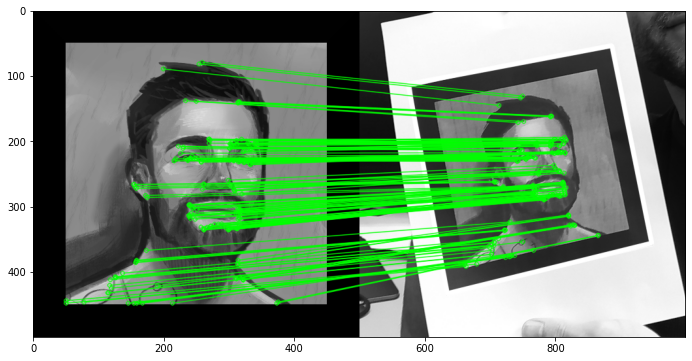

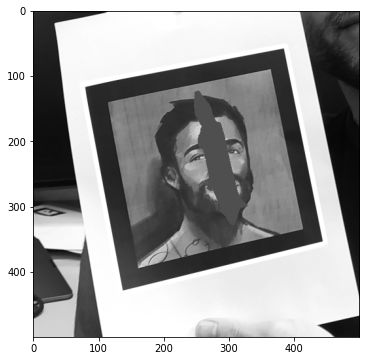

In [15]:
pipeline(ref_image2, src_image5, orb, bf_matcher)

In this case, without background noise, the feature matching and homography calculation worked perfectly.

# Improvements

The feature matching wasn't working at all, exhibiting the same problems as in the first assignment with the rectangle detection. The features would flicker all over the place, causing the homography to flicker out of control and the model to fly randomly around the scene. This was fixed by adjusting some parameters and fixing return values of the pipeline functions.


![Problem: feature matching](./docs/problem_feature-matching-fail.png "Problem: feature matching")

Also, it might be the case that the input resolution affects feature matching performance. To test this hypothesis, I scaled down the image that completely failed due to the background (`src_image4`). Here's the results on a 500x500 resolution:

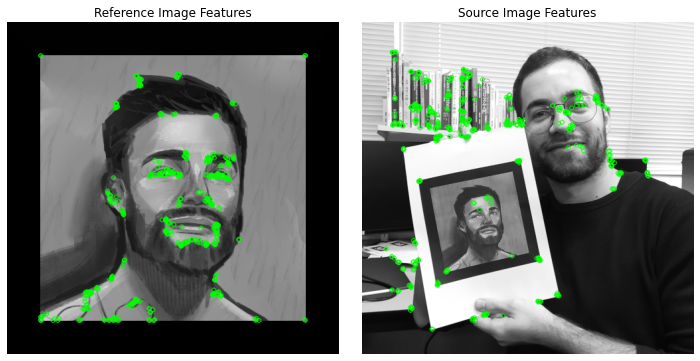

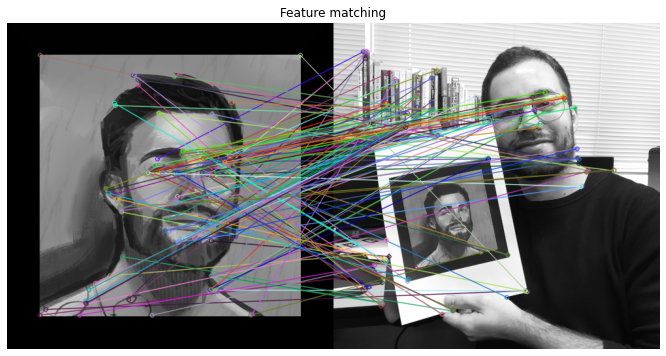

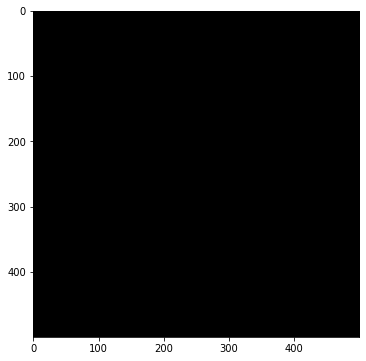

In [16]:
src_image6 = cv2.imread('./img/src_me-small.png', 0)
pipeline(ref_image2, src_image6, orb, bf_matcher)

The results still failed. This confirms that the background has a big influence on the results. The optimal solution is to remove the background as much as possible, leaving the marker itself as the dominant part of the image. This could be achieved by using the first assignments results, rectangular detection, to create a bounding box around the marker and only apply feature detection to that region.